In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

from utils import set_random_seed
set_random_seed(seed=0)

In [102]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 784)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = F.tanh(self.fc1(z))
        z = F.tanh(self.fc2(z))
        return z


class SimpleAE(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(SimpleAE, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        o = self.decoder(z)
        return o
    
    def loss_fn(self, x: torch.Tensor, x_hat: torch.Tensor) -> float:
        mse = torch.mean((x - x_hat)**2) # by pixel
        return mse
    
    def reg_weights_loss_fn(self, lam: float) -> float:
        learnable_weights = [p for p in self.parameters() if p.requires_grad and p.dim() > 1]
        loss = lam * torch.sum(torch.tensor([torch.sum(w**2) for w in learnable_weights]))
        return loss
    
    def reg_clarity_loss_fn(self, lam: float, x_hat) -> float:
        # penalize pixels close to 0
        clear_loss = lam * torch.mean((1 + x_hat) * (1 - x_hat)) # by pixel
        return clear_loss


In [98]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)) # (x/255 - 0.5) / 0.5
])

data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset=data, batch_size=128, shuffle=True, drop_last=True)

for x, _ in tqdm(dataloader):
    break

  0%|          | 0/468 [00:00<?, ?it/s]


In [101]:
epochs = 5
latent_dim = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = SimpleAE(latent_dim).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

for epoch in range(epochs):
    for batch, (x, _) in enumerate(dataloader):
        
        x = torch.flatten(x, start_dim=1, end_dim=-1) # [B, 1, 784]
        x = x.to(device)
        x_hat = autoencoder(x) # [B, 1, 784]

        loss = autoencoder.loss_fn(x, x_hat)
        reg_weights_loss = autoencoder.reg_weights_loss_fn(lam=1e-5)
        reg_clarity_loss = autoencoder.reg_clarity_loss_fn(x_hat=x_hat, lam=5e-1)
        total_loss = loss + reg_weights_loss + reg_clarity_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print(
                f"epoch = {epoch}",
                f"batch = {batch:03d}", 
                f"MSE: {loss.item():.4f}", 
                f"REG WEIGHTS: {reg_weights_loss.item():.4f}", 
                f"REG CLARITY: {reg_clarity_loss.item():.4f}",
                f"total loss: {total_loss.item():.4f}"
            )

    print()

epoch = 0 batch = 000 MSE: 0.9267 REG WEIGHTS: 0.0035 REG CLARITY: 0.4933 total loss: 1.4235
epoch = 0 batch = 100 MSE: 0.3210 REG WEIGHTS: 0.0044 REG CLARITY: 0.0954 total loss: 0.4209
epoch = 0 batch = 200 MSE: 0.3006 REG WEIGHTS: 0.0046 REG CLARITY: 0.0947 total loss: 0.3999
epoch = 0 batch = 300 MSE: 0.2920 REG WEIGHTS: 0.0052 REG CLARITY: 0.0864 total loss: 0.3836
epoch = 0 batch = 400 MSE: 0.2495 REG WEIGHTS: 0.0059 REG CLARITY: 0.0816 total loss: 0.3370

epoch = 1 batch = 000 MSE: 0.2552 REG WEIGHTS: 0.0064 REG CLARITY: 0.0748 total loss: 0.3363
epoch = 1 batch = 100 MSE: 0.2359 REG WEIGHTS: 0.0071 REG CLARITY: 0.0712 total loss: 0.3141
epoch = 1 batch = 200 MSE: 0.2375 REG WEIGHTS: 0.0079 REG CLARITY: 0.0608 total loss: 0.3061
epoch = 1 batch = 300 MSE: 0.2321 REG WEIGHTS: 0.0086 REG CLARITY: 0.0620 total loss: 0.3027
epoch = 1 batch = 400 MSE: 0.2263 REG WEIGHTS: 0.0094 REG CLARITY: 0.0602 total loss: 0.2959

epoch = 2 batch = 000 MSE: 0.2160 REG WEIGHTS: 0.0100 REG CLARITY: 0

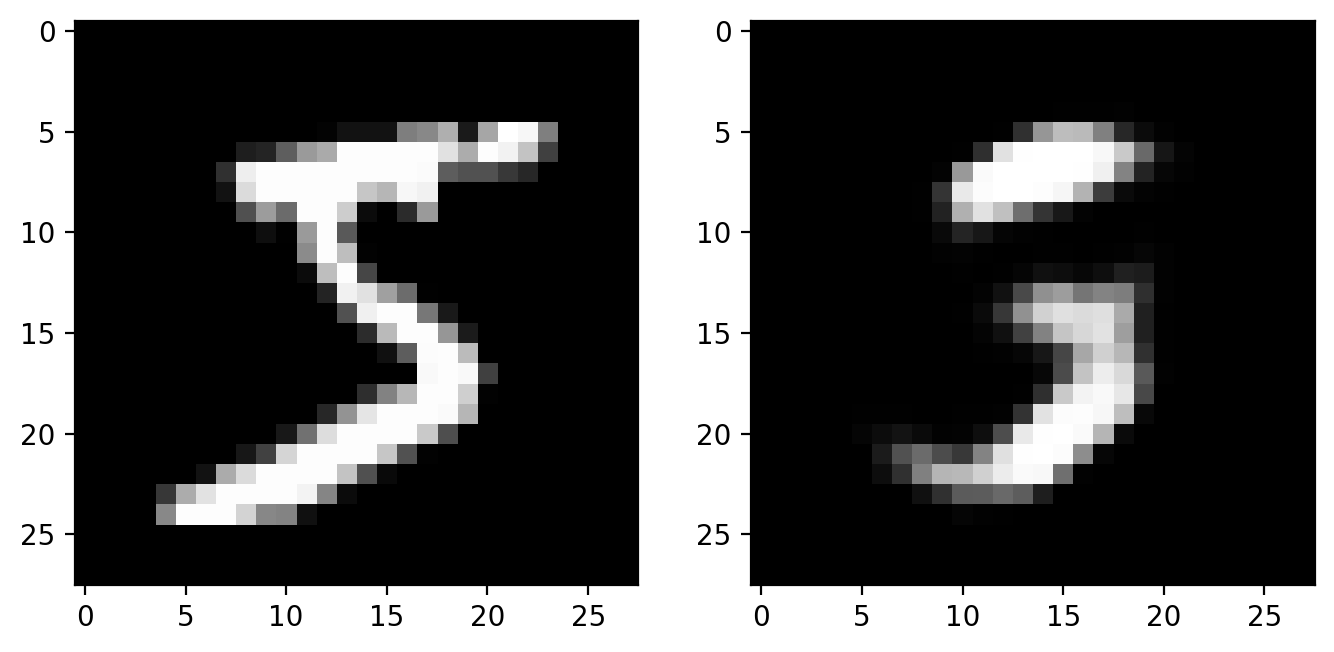

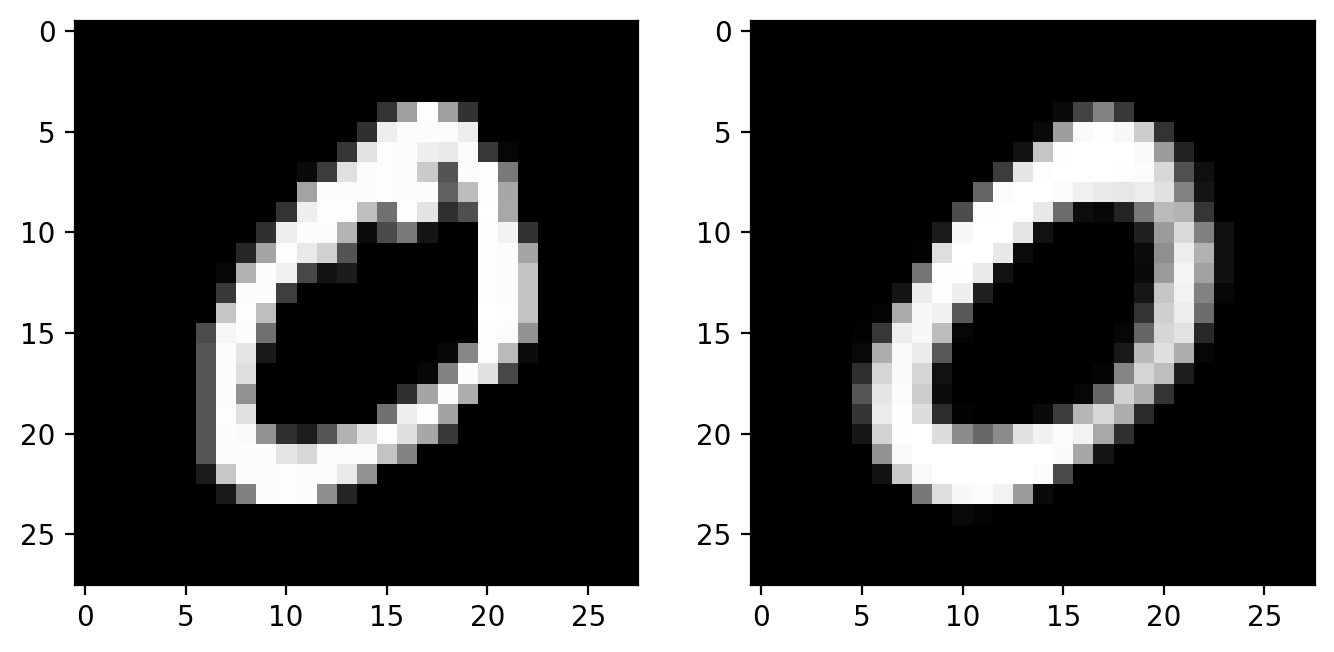

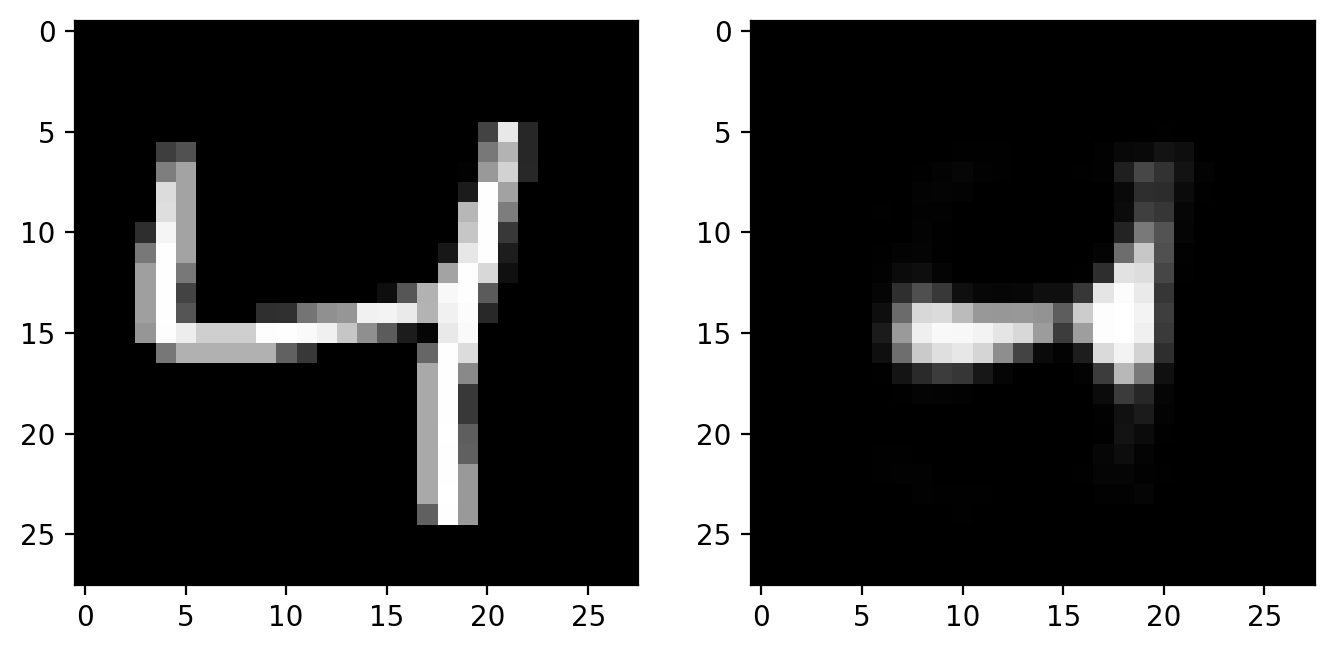

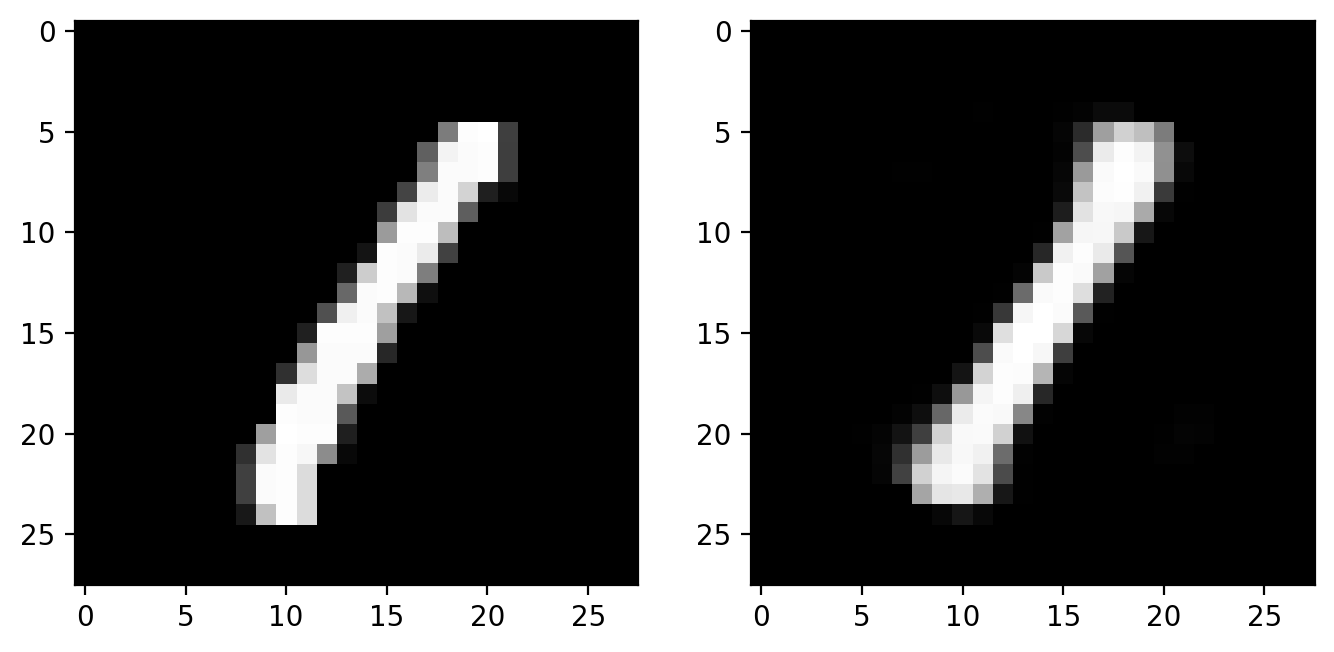

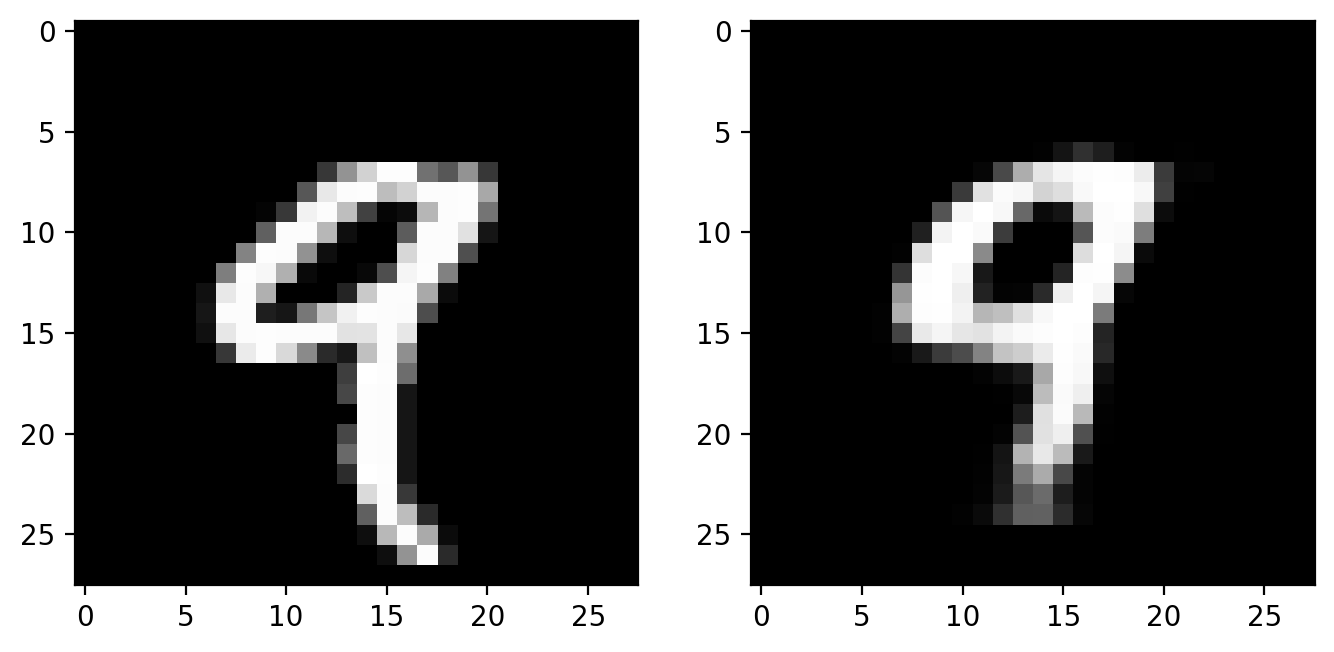

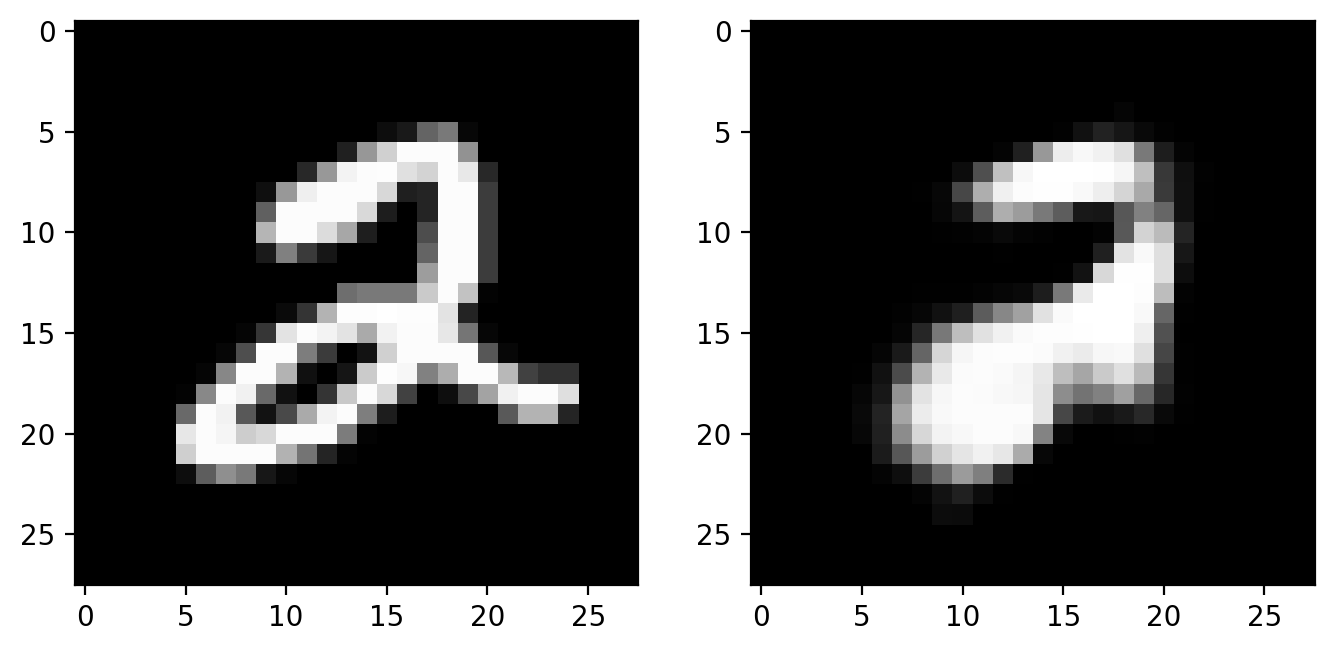

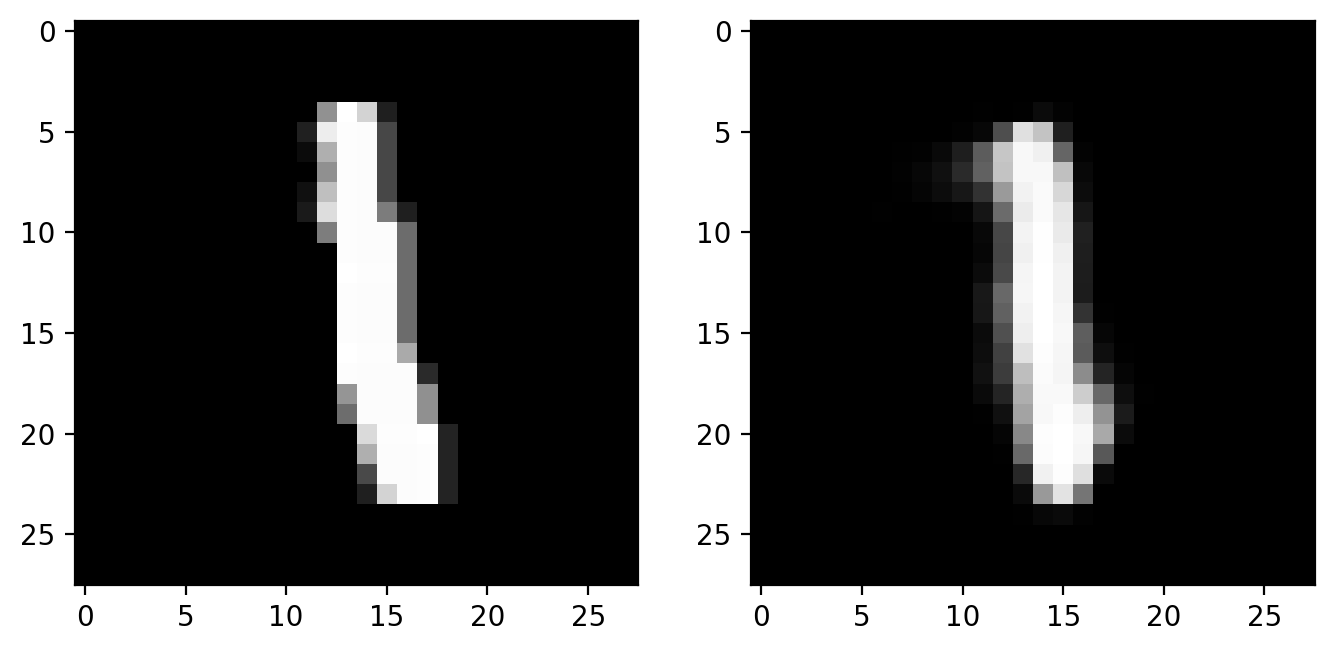

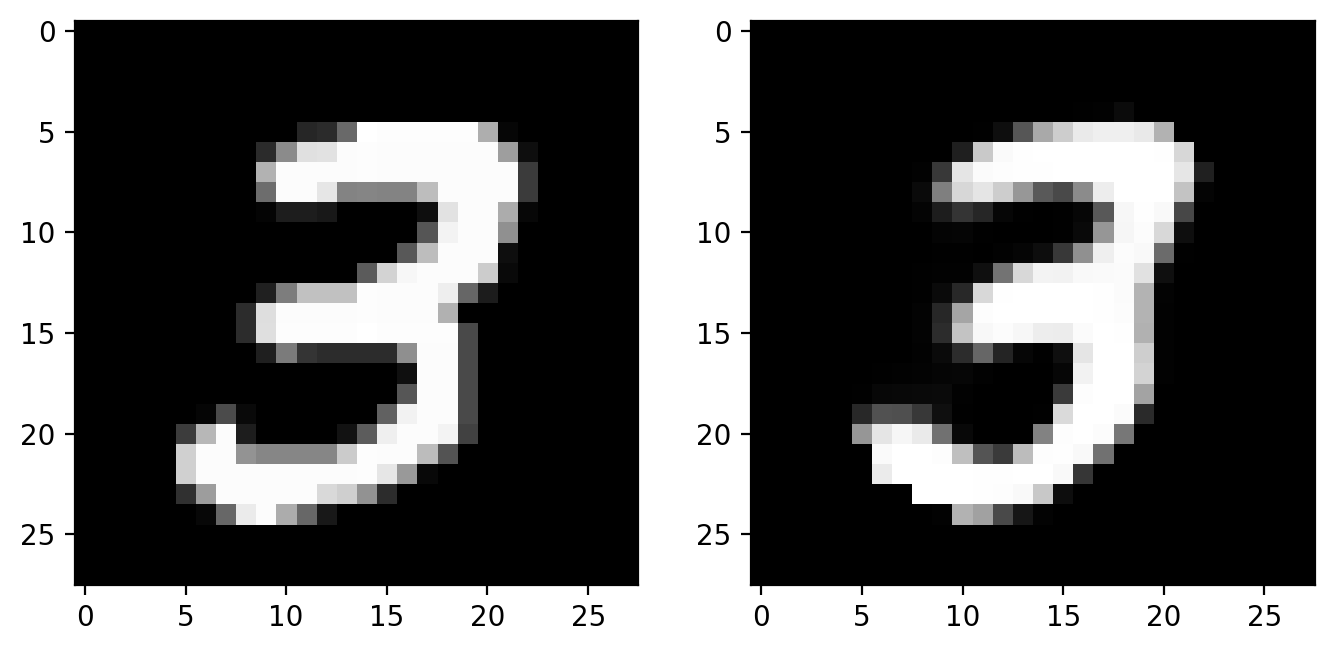

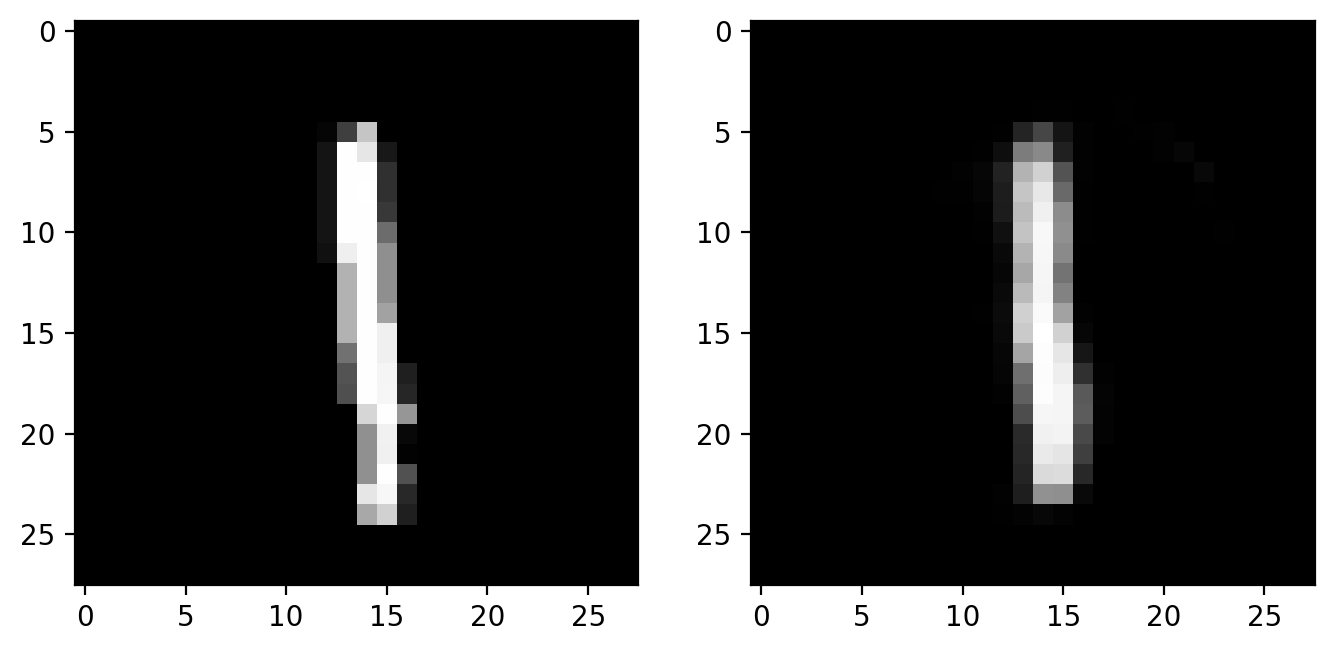

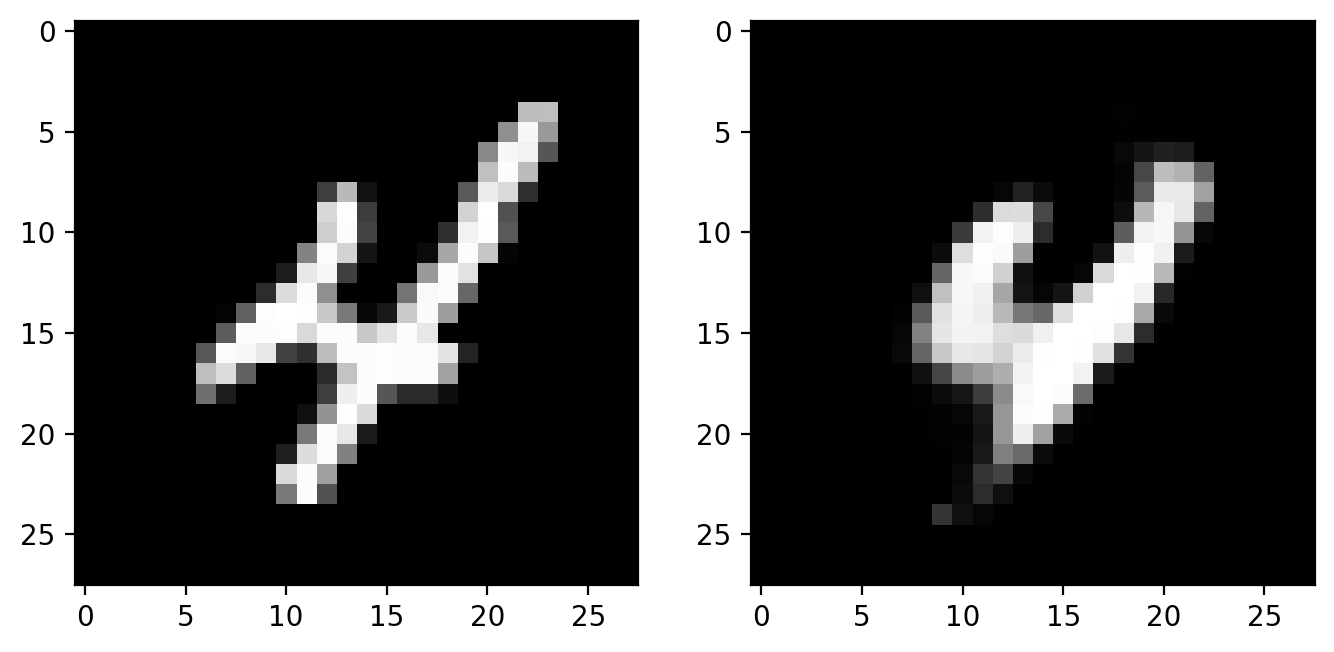

In [103]:
for i in range(10):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

    ex = data[i][0][0]
    ax1.imshow(ex, cmap='gray');

    ex_inp = ex.unsqueeze(0)
    ex_inp = torch.flatten(ex_inp, start_dim=1, end_dim=-1)
    ax2.imshow(autoencoder(ex_inp).view(28,28).detach().numpy(), cmap='gray');

    plt.show()